# Full Code Version 3
This script will contain the full code for the SU2 local mesh refinement.

**Installing the correct packages** <br>
To connect Paraview with Python some additional packages need to be installed. This only needs to be done once, then they can be commented out.

In [1]:
#conda install -c anaconda vtk

In [2]:
#pip install pyvistaqt

**Importing the required packages** <br>
The packages below need to be loaded in for the rest of the code to work.

In [3]:
import numpy as np
import pyvista as pv
from pyvista import examples
import vtk
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pyvistaqt as pvqt
import math
import os

**Renaming the original mesh file** <br>
The original mesh file is renamed to 'original_mesh.su2'. This is done to make sure the new mesh can be saved without overwritting the original mesh, and that SU2 can easily run the simulation again.

In [4]:
# path of the file
old_name = r"C:\\Users\\20192167\\Documents\\Boeken\\BEP\\SU2-master\\SU2-master\\QuickStart\\mesh_NACA0012_inv.su2"
new_name = r"C:\\Users\\20192167\\Documents\\Boeken\\BEP\\SU2-master\\SU2-master\\QuickStart\\original_mesh.su2"

# Renaming the file
os.rename(old_name, new_name)

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'C:\\\\Users\\\\20192167\\\\Documents\\\\Boeken\\\\BEP\\\\SU2-master\\\\SU2-master\\\\QuickStart\\\\mesh_NACA0012_inv.su2' -> 'C:\\\\Users\\\\20192167\\\\Documents\\\\Boeken\\\\BEP\\\\SU2-master\\\\SU2-master\\\\QuickStart\\\\original_mesh.su2'

**Loading in the SU2 data** <br>
The results from the SU2 flow analysis are loaded in with the code below. The flow analysis contains several data variables, each assigned to a different Python variable.

In [5]:
pd = pv.read('C:/Users/20192167/Documents/Boeken/BEP/SU2-master/SU2-master/QuickStart/flow.vtu')
pd

UnstructuredGrid (0x2509c628f40)
  N Cells:	10216
  N Points:	5233
  X Bounds:	-2.000e+01, 2.000e+01
  Y Bounds:	-1.996e+01, 1.996e+01
  Z Bounds:	0.000e+00, 0.000e+00
  N Arrays:	7

In [6]:
density = pd['Density'].copy()
momentum = pd['Momentum'].copy() #is een 3 by 5428 array... hoe visualizeren?
energy = pd['Energy'].copy()
pressure = pd['Pressure'].copy()
temperature = pd['Temperature'].copy()
mach = pd['Mach'].copy()
pressure_coefficient = pd['Pressure_Coefficient'].copy()

**Visualizing the distribution**

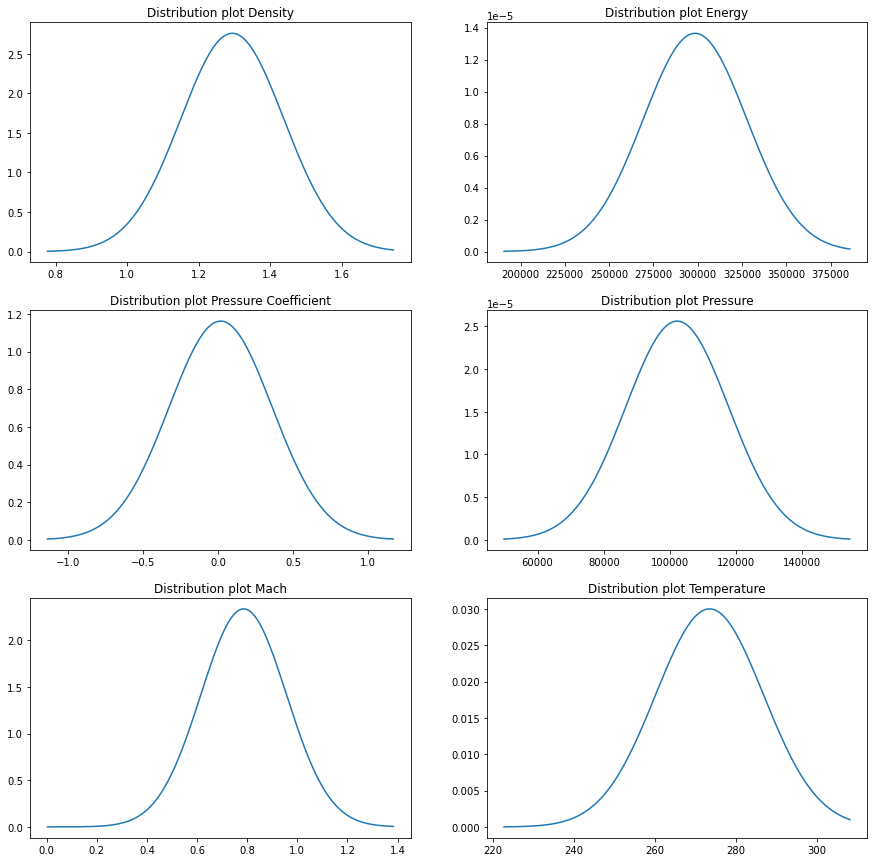

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(15,15))

density.sort()
mean = np.mean(density)
std = np.std(density)
axs[0,0].plot(density, norm.pdf(density, mean, std))
axs[0,0].set_title("Distribution plot Density")


energy.sort()
mean = np.mean(energy)
std = np.std(energy)
axs[0, 1].plot(energy, norm.pdf(energy, mean, std))
axs[0, 1].set_title("Distribution plot Energy")

pressure.sort()
mean = np.mean(pressure)
std = np.std(pressure)
axs[1, 1].plot(pressure, norm.pdf(pressure, mean, std))
axs[1, 1].set_title("Distribution plot Pressure")

temperature.sort()
mean = np.mean(temperature)
std = np.std(temperature)
axs[2, 1].plot(temperature, norm.pdf(temperature, mean, std))
axs[2, 1].set_title("Distribution plot Temperature")

mach.sort()
mean = np.mean(mach)
std = np.std(mach)
axs[2, 0].plot(mach, norm.pdf(mach, mean, std))
axs[2, 0].set_title("Distribution plot Mach")

pressure_coefficient.sort()
mean = np.mean(pressure_coefficient)
std = np.std(pressure_coefficient)
axs[1, 0].set_title("Distribution plot Pressure Coefficient")
axs[1, 0].plot(pressure_coefficient, norm.pdf(pressure_coefficient, mean, std))



**Visualizing the Data in Paraview** (Example Temperature)<br>
The code below can be used to vizualize the SU2 results in Paraview.

In [8]:
# Define the colors we want to use
green = np.array([200/256, 247/256, 0/256, 1])
greenblue = np.array([12/256, 238/256, 200/256, 1])
blue = np.array([12/256, 238/256, 246/256, 1])
darkblue = np.array([12/256, 150/256, 246/256, 1])
purple= np.array([200/256, 50/256, 246/256, 1])
pink= np.array([250/256, 50/256, 246/256, 1])
lightpink = np.array([250/256, 50/256, 246/256, 0.7])
orange = np.array([250/256, 150/256, 0/256, 0.7])
yelloworange = np.array([250/256, 200/256, 0/256, 0.7])
yellow = np.array([255/256, 247/256, 0/256, 1])
grey = np.array([189/256, 189/256, 189/256, 1])

Temperature = np.linspace(pd['Temperature'].min(), pd['Temperature'].max(), 256)

newcolors = np.empty((256, 4))
newcolors[Temperature >= 200] = green
newcolors[Temperature > 210] = greenblue
newcolors[Temperature > 220] = blue
newcolors[Temperature > 230] = darkblue
newcolors[Temperature > 240] = purple
newcolors[Temperature > 250] = pink
newcolors[Temperature > 260] = lightpink
newcolors[Temperature > 270] = orange
newcolors[Temperature > 280] = yelloworange
newcolors[Temperature > 290] = yellow
newcolors[Temperature >= 300] = grey

my_colormap = ListedColormap(newcolors)

pl = pvqt.BackgroundPlotter()
pl.set_background('white')
pv.global_theme.font.color = 'black'
pl.add_mesh(pd, show_edges=True, line_width=0.5,scalars='Temperature',
            cmap=my_colormap,clim=[200, 300])
pl.camera_position = 'xy'
pl.show()

**Sorting the data per cell** (Example Temperature) <br>
To make sure that the correct cells can be indicated an average per cell will be calculated. 'data_variable' indicated the variable you wish to base your local mesh refinement on. 

In [9]:
data_variable = 'Temperature' # 'Density', 'Momentum', 'Energy', 'Pressure', 'Temperature', 'Mach', 'Pressure_Coefficient'
cells=pd.cells
points=pd.points

Centers = []
cellsC = cells

while True:
    if cellsC[0]==3:
        a = cellsC[1]
        b = cellsC[2]
        c = cellsC[3]
        
        C = (pd[data_variable][a]+pd[data_variable][b] +pd[data_variable][c])/3
        Centers.append(C)
        cellsC = cellsC[4:]
        
    elif cellsC[0]==4:
        a = cellsC[1]
        b = cellsC[2]
        c = cellsC[3]
        d = cellsC[4]
        
        C = (pd[data_variable][a]+pd[data_variable][b] +pd[data_variable][c]+pd[data_variable])/4
        Centers.append(C)
        cellsC = cellsC[5:]
    
    if len(cellsC) == 0:
        break

**Determining which cells should be refined** <br>
Based on the visualizations above the user can determine the variable on which the local mesh refinement should be based. Then the code below can be used to for filter the cells based on that data variable. This can be done with a minimum or maximum value filter or with a minimum or maximum percentage filter. 

In [10]:
Index = []
Option= 1 # 1=min or max value, 2 = min or max percentage

if Option == 1:
    for x in range(0, len(Centers)):
        if Centers[x] <= 250:
            Index.append(x)
            
elif Option == 2:
    margin = np.percentile(Centers, 90)

    for x in range(0, len(Centers)):
        if Centers[x] >= margin:
            Index.append(x)

In [11]:
Index

[7,
 10,
 12,
 17,
 22,
 24,
 28,
 56,
 59,
 69,
 97,
 111,
 112,
 113,
 114,
 117,
 124,
 125,
 129,
 134,
 135,
 136,
 140,
 141,
 142,
 144,
 145,
 146,
 147,
 148,
 149,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 177,
 189,
 192,
 193,
 195,
 421,
 427,
 433,
 506,
 509,
 524,
 525,
 530,
 531,
 549,
 552,
 553,
 554,
 610,
 612,
 613,
 618,
 619,
 625,
 657,
 666,
 679,
 688,
 691,
 700,
 701,
 709,
 710,
 712,
 713,
 716,
 717,
 718,
 719,
 726,
 727,
 731,
 736,
 744,
 745,
 748,
 749,
 750,
 752,
 753,
 754,
 755,
 756,
 757,
 758,
 759,
 760,
 761,
 762,
 763,
 764,
 765,
 766,
 767,
 768,
 769,
 772,
 773,
 796,
 808,
 809,
 812,
 813,
 816,
 817,
 818,
 819,
 820,
 821,
 822,
 823,
 824,
 825,
 826,
 827,
 830,
 831,
 834,
 835,
 847,
 850,
 851,
 857,
 858,
 859,
 860,
 861,
 866,
 867,
 872,
 873,
 890,
 891,
 906,
 908,
 916,
 917,
 961,
 964,
 965,
 967,
 968,
 969,
 974,
 975,
 976,
 977,
 988,
 989,
 990,
 991,
 992,
 993,
 994,
 995,
 1002,
 1003,
 1040,
 

**Loading in the SU2 mesh file** <br>
Next the original SU2 mesh file will be loaded into Python. Additionally, the code will be prepared for processing.

In [12]:
f = open(new_name, 'r')


# first get the dimensions
line = f.readline()
columns = line.split()
print(columns)

NDIME = columns[1]
print("dimensions = ",NDIME)

# then, get the nr of elements
line = f.readline()
columns = line.split()

NELEM=columns[1]
print("nr of elements=",NELEM)

# create the 2D triangle array
connectivity = np.arange(4*int(NELEM),dtype=np.int32)
connectivity = connectivity.reshape(int(NELEM),4)
                    
# now, read all the elements into a structure
for i in range(int(NELEM)):
    line=f.readline()
    columns = line.split()
    connectivity[i][:]=[int(3), int(columns[1]), int(columns[2]), int(columns[3])]
    
print("end reading elements")
# then, get the coordinates
line = f.readline()
columns = line.split()

NPOIN=columns[1]
print("nr of points=",NPOIN)

# create the 2D point array
points = np.arange(2*int(NPOIN),dtype=np.float64).reshape(int(NPOIN),2)
# now, read all the points into a structure
for i in range(int(NPOIN)):
    line=f.readline()
    columns = line.split()
    points[i][0]=float(columns[0])
    points[i][1]=float(columns[1])

# now, read the markers
line = f.readline()
columns = line.split()

NMARK=columns[1]
print("nr of markers=",NMARK)

# name of the marker (list of strings)
markername = []
# number of elements in the marker (list of integers)
markerelements = np.arange(int(NMARK),dtype=np.int32)
# this is the list of numpy arrays
markers = []

# list of marker points
markerpointslist = []

for m in range(int(NMARK)):
    line = f.readline()
    columns = line.split()
    markername.append(columns[1])
    print(" ",m,": marker name=",markername[m])
    line = f.readline()
    columns = line.split()
    markerelements[m] = int(columns[1])   
    print(" marker elements=",markerelements[m])
    markerarray = np.arange(2*int(markerelements[m])).reshape(int(markerelements[m]),2)

    for i in range(int(markerelements[m])):
        line=f.readline()
        columns = line.split()
        markerarray[i][0]=columns[1]
        markerarray[i][1]=columns[2]
        
    # now add the array to the list of markers
    markers.append(markerarray)

print("Finished reading su2 file.") 

['NDIME=', '2']
dimensions =  2
nr of elements= 10216
end reading elements
nr of points= 5233
nr of markers= 2
  0 : marker name= airfoil
 marker elements= 200
  1 : marker name= farfield
 marker elements= 50
Finished reading su2 file.


In [13]:
connectivity

array([[   3,  417,   69,  311],
       [   3,  302,   55,   56],
       [   3,  405,  159,  384],
       ...,
       [   3, 5105, 5061, 5029],
       [   3, 5134, 5106, 5097],
       [   3, 5122, 5109, 5075]])

In [14]:
n = int(NPOIN)
z = np.zeros((n, 1))
p = np.append(points, z, axis=1)
points = p
points

array([[ 9.99750018e-01, -3.63289652e-05,  0.00000000e+00],
       [ 9.99000013e-01, -1.45253750e-04,  0.00000000e+00],
       [ 9.97759998e-01, -3.25111163e-04,  0.00000000e+00],
       ...,
       [ 1.75493202e+01,  3.08875299e+00,  0.00000000e+00],
       [ 1.14168196e+01,  1.40551205e+01,  0.00000000e+00],
       [ 1.71931591e+01,  7.91305924e+00,  0.00000000e+00]])

In [15]:
markers0 = markers

**Visualizing the mesh with Paraview** <br>
The original mesh will be visualized with Paraview to later confirm the refinement of the desired cells.

In [16]:
mesh = pv.PolyData(points, connectivity)
pl = pvqt.BackgroundPlotter()
pl.add_mesh(mesh, show_edges=True, line_width=0.05, color='#EEEEEE')
pl.set_background('white')
#pl.add_point_labels(points, [f'Point {i}' for i in range(5)],always_visible=True,
#                    font_size=20,text_color='white', point_size=20,point_color='red',render_points_as_spheres=True)
pl.camera_position = 'xy'
pl.show()

**Mesh Quality of the original mesh** <br>
Before refining the mesh, the mesh quality of the original mesh will be determined.

In [17]:
if connectivity[0][0] == 3: #If the mesh is triangular
    z1 = 3
    z2 = 5
    qe = 60
    
elif connectivity[0][0] == 4: #is the mesh is square
    z1 = 4
    z2 = 6
    qe = 90
    z3 = 2

q = len(connectivity) #Total number of cells
p = [] #A temporary array to store the points of the cell of interest
i = 0

#----------------------------------------------------------------------------#
#-----------------Aspect Ratio-----------------------------------------------#
#----------------------------------------------------------------------------#

aspect_ratio_original = []
distance = [] #A temporary array containing the lenghts of the edges

for y in range(0,q):
    for x in range(1,z2):
        if i < z1:
            a = points[connectivity[y][x]]
            p.append(a)
            i = i+1
        elif i == z1:
            for x in range(0,z1):
                l = abs(p[x%z1]-p[(x+1)%z1]) # calculates the difference in x and y coordinates of the points
                d = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
                distance.append(d)
            ar = min(distance)/max(distance)
            aspect_ratio_original.append(ar)
            i = 0
            p =[]
            distance = []

i = 0
Skewness_original = []
distance = []

for y in range(0,q):
    for x in range(1,z2):
        if i < z1:
            a = points[connectivity[y][x]]
            p.append(a)
            i = i+1
        elif i == z1:
            
            if z1 ==3:
                for x in range(0,z1):
                    l = abs(p[x%z1]-p[(x+1)%z1]) # calculates the difference in x and y coordinates of the points
                    d = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
                    distance.append(d)
                a = distance[1]
                b = distance[2]
                c = distance[0]
                alpha = math.degrees(math.acos((a**2-b**2-c**2)/(-2*b*c))) #calculates the angles of the corners
                beta = math.degrees(math.acos((b**2-c**2-a**2)/(-2*c*a)))
                gamma = math.degrees(math.acos((c**2-b**2-a**2)/(-2*b*a)))
                qmin = min(alpha, beta, gamma) #determines the minimal angle
                qmax = max(alpha, beta, gamma) #determines the maximal angle
                
            elif z1 == 4:
                for x in range(0,z1):
                    l = abs(p[x%z1]-p[(x+1)%z1]) # calculates the difference in x and y coordinates of the points
                    d = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
                    distance.append(d)
                a = distance[0]
                b = distance[1]
                c = distance[2]
                d = distance[3]
                
                for x in range(0,z3):
                    l = abs(p[x%z1]-p[(x+2)%z1]) # calculates the difference in x and y coordinates of the points
                    d2 = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
                    distance.append(d2)
                    
                e = distance[4]
                f = distance[5]
                alpha1 = math.degrees(math.acos((b**2-e**2-a**2)/(-2*e*a))) #calculates the angles of the corners
                alpha2 = math.degrees(math.acos((d**2-f**2-c**2)/(-2*f*c)))
                beta = math.degrees(math.acos((e**2-a**2-b**2)/(-2*a*b)))
                gamma1 = math.degrees(math.acos((a**2-e**2-b**2)/(-2*e*b)))
                gamma2 = math.degrees(math.acos((c**2-d**2-f**2)/(-2*d*f)))
                gamma = gamma2+alpha2
                alpha = gamma1+alpha1
                delta = math.degrees(math.acos((f**2-d**2-c**2)/(-2*d*c)))
                qmin = min(alpha, beta, gamma, delta) #determines the minimal angle
                qmax = max(alpha, beta, gamma, delta) #determines the maximal angle
            skewness = max((qmax-qe)/(180-qe), (qe-qmin)/qe) 
            Skewness_original.append(skewness)
            i = 0
            p =[]
            distance = []
            

len_cells = len(connectivity) #the total number of cells in the mesh
len_points = len(points)
Orthogonality_original = []

if z1 ==3: #if triangle
    for y in range(0,len_cells):
        p=[]
        i = 0
        
        d = connectivity[y][1]
        e = connectivity[y][2]
        f = connectivity[y][3]
    
        for x in range(1,5):
            if i < z1:
                a = points[connectivity[y][x]]
                p.append(a)
                i = i+1
            elif i == z1:
                center = (p[0]+p[1]+p[2])/3
                point1 = ((points[e]+points[d])/2) #creating a additional point in the middle of the first edge of the side
                point2 = ((points[f]+points[e])/2) #creating a additional point in the middle of the second edge of the side
                point3 = ((points[d]+points[f])/2) #creating a additional point in the middle of the third edge of the side 
                
                e1= point1-center #center to point1
                e2= point2-center #center to point2
                e3= point3-center #center to point3
                vectors_e = [e1[:2],e2[:2],e3[:2]]
                
                v1= points[e]-points[d]
                v2= points[f]-points[e]
                v3= points[d]-points[f]
                
                #v=(a,b) u=(b,-a) #perpendicular
                A1= (v1[1],-v1[0]) #perpendicular to side de
                A2= (v2[1],-v2[0])#perpendicular to side ef
                A3= (v3[1],-v3[0])#perpendicular to side fd
                vectors_A=[A1,A2,A3]
                
                orth = []
                for o in range(0,3):
                    dot_e_A = abs((vectors_A[o][0]*vectors_e[o][0])+(vectors_A[o][1]*vectors_e[o][1]))
                    magnitude_e = math.sqrt((vectors_e[o][0])**2+(vectors_e[o][1])**2)
                    magnitude_A = math.sqrt((vectors_A[o][0])**2+(vectors_A[o][1])**2)
                    ort = (dot_e_A)/(magnitude_e*magnitude_A)
                    orth.append(ort)
                Orthogonality_original.append(min(orth))

                                        
elif z1==4: #if square

    for y in range(0,len_cells):
        p=[]
        i = 0
        
        d = connectivity[y][1]
        e = connectivity[y][2]
        f = connectivity[y][3]
        g = connectivity[y][4]
        
        for x in range(1,6):
            if i < z1:
                a = points[connectivity[y][x]]
                p.append(a)
                i = i+1
            elif i == z1:
                center = (p[0]+p[1]+p[2]+p[3])/4
                point1 = ((points[e]+points[d])/2) #creating a additional point in the middle of the first edge of the side
                point2 = ((points[f]+points[e])/2) #creating a additional point in the middle of the second edge of the side
                point3 = ((points[g]+points[f])/2) #creating a additional point in the middle of the third edge of the side
                point4 = ((points[f]+points[d])/2) #creating a additional point in the middle of the third edge of the side
                
                e1= point1-center #center to point1
                e2= point2-center #center to point2
                e3= point3-center #center to point3
                e4= point4-center #center to point4
                vectors_e = [e1[:2],e2[:2],e3[:2], e4[:2]]
                
                v1= points[e]-points[d]
                v2= points[f]-points[e]
                v3= points[g]-points[f]
                v4= points[d]-points[g]
                
                #v=(a,b) u=(b,-a) #perpendicular
                A1= (v1[1],-v1[0]) #perpendicular to side de
                A2= (v2[1],-v2[0])#perpendicular to side ef
                A3= (v3[1],-v3[0])#perpendicular to side fg
                A4= (v4[1],-v4[0])#perpendicular to side gd
                vectors_A=[A1,A2,A3,A4]
                
                orth = []
                for o in range(0,4):
                    dot_e_A = abs((vectors_A[o][0]*vectors_e[o][0])+(vectors_A[o][1]*vectors_e[o][1]))
                    magnitude_e = math.sqrt((vectors_e[o][0])**2+(vectors_e[o][1])**2)
                    magnitude_A = math.sqrt((vectors_A[o][0])**2+(vectors_A[o][1])**2)
                    ort = (dot_e_A)/(magnitude_e*magnitude_A)
                    orth.append(ort)
                Orthogonality_original.append(min(orth))

      
        
print('The average Aspect Ratio of the original mesh is', round(sum(aspect_ratio_original)/len(aspect_ratio_original),3))
print('The minimum Aspect Ratio of the original mesh is', round(min(aspect_ratio_original),3))
print('the maximum Aspect Ratio of the original mesh is', round(max(aspect_ratio_original),3))

print('The average Skewness of the original mesh is', round(sum(Skewness_original)/len(Skewness_original),3))
print('The minimum Skewness of the original mesh is', round(min(Skewness_original),3))
print('the maximum Skewness of the original mesh is', round(max(Skewness_original),3))

print('The average Face Orthogonality of the mesh is', round(sum(Orthogonality_original)/len(Orthogonality_original),3))
print('The minimum Face Orthogonality of the mesh is', round(min(Orthogonality_original),3))
print('The maximum Face Orthogonality of the mesh is', round(max(Orthogonality_original),3))      

The average Aspect Ratio of the original mesh is 0.833
The minimum Aspect Ratio of the original mesh is 0.343
the maximum Aspect Ratio of the original mesh is 1.0
The average Skewness of the original mesh is 0.159
The minimum Skewness of the original mesh is 0.0
the maximum Skewness of the original mesh is 0.666
The average Face Orthogonality of the mesh is 0.967
The minimum Face Orthogonality of the mesh is 0.571
The maximum Face Orthogonality of the mesh is 1.0


C:\Users\20192167\Anaconda3\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


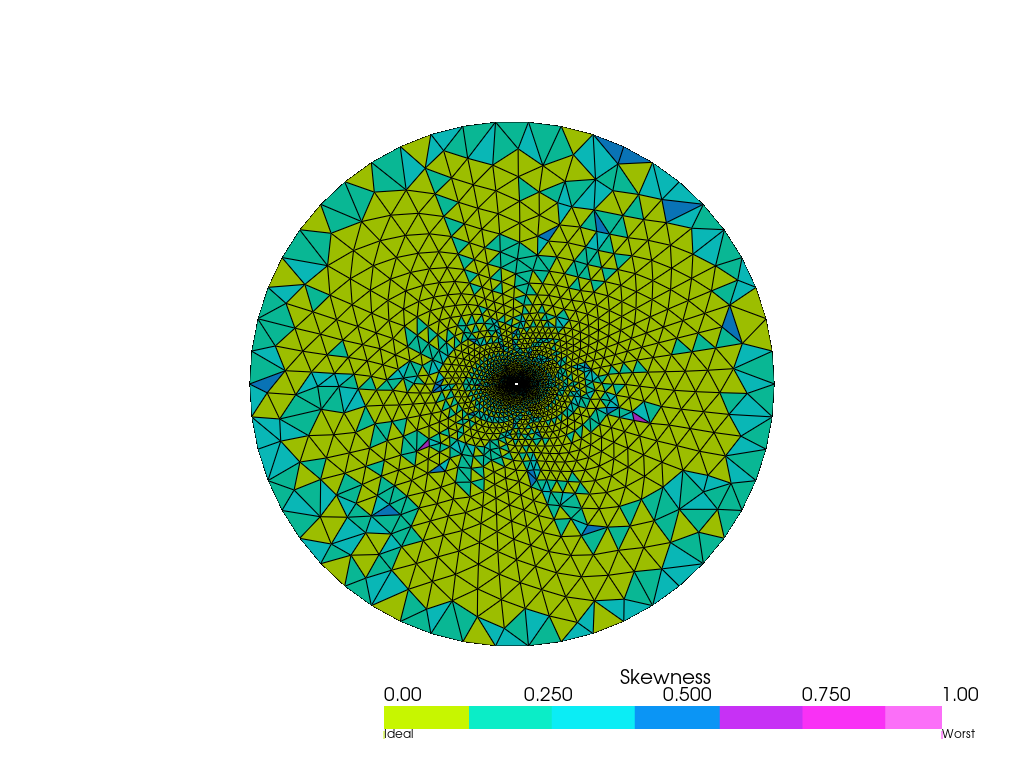

In [18]:
mesh.cell_data['Skewness']= Skewness_original

# Define the colors we want to use
green = np.array([200/256, 247/256, 0/256, 1])
greenblue = np.array([12/256, 238/256, 200/256, 1])
blue = np.array([12/256, 238/256, 246/256, 1])
darkblue = np.array([12/256, 150/256, 246/256, 1])
purple= np.array([200/256, 50/256, 246/256, 1])
pink= np.array([250/256, 50/256, 246/256, 1])
lightpink = np.array([250/256, 50/256, 246/256, 0.7])
orange = np.array([250/256, 150/256, 0/256, 0.7])
yelloworange = np.array([250/256, 200/256, 0/256, 0.7])
yellow = np.array([255/256, 247/256, 0/256, 1])
grey = np.array([189/256, 189/256, 189/256, 1])

skewness = np.linspace(mesh['Skewness'].min(), mesh['Skewness'].max(), 256)
newcolors = np.empty((256, 4))
newcolors[skewness >= 0] = green
#newcolors[skewness > 0.1] = lightgreen
newcolors[skewness > 0.1] = greenblue
newcolors[skewness > 0.2] = blue
newcolors[skewness > 0.3] = darkblue
newcolors[skewness > 0.4] = purple
newcolors[skewness > 0.5] = pink
newcolors[skewness > 0.6] = lightpink
newcolors[skewness > 0.7] = orange
newcolors[skewness > 0.8] = yelloworange
newcolors[skewness > 0.9] = yellow
newcolors[skewness >= 1] = grey

my_colormap = ListedColormap(newcolors)
annotations = {
    1: "Worst",
    0: "Ideal",
}

pl = pv.Plotter()
pl.set_background('white')
pv.global_theme.font.color = 'black'
pl.add_mesh(mesh, show_edges=True, line_width=0.5,scalars='Skewness',
            cmap=my_colormap, annotations=annotations,clim=[0, 1])
pl.camera_position = 'xy'
pl.show()

**Refining the mesh** <br>


In [22]:
c = Index.copy()

In [23]:
#----------------------------------------------#
#---------Rewritting the cells array-----------#
#----------------------------------------------#
cells=[]
for x in range(0,len(connectivity)):
    for y in range(0, len(connectivity[x])):
        cells.append(connectivity[x][y])

In [33]:
print('Saving the cell types')
#----------------------------------------------#
#-----------Saving the cell types--------------#
#----------------------------------------------#
cells_type = cells.copy()
Type = []
ytotal = []
ytotaly = []

while True:
    if cells_type[0]==3:
        Type.append(3)
        cells_type= cells_type[4:]
        
    elif cells_type[0]==4:
        Type.append(4)
        cells_type= cells_type[5:]

    if len(cells_type) == 0:
        break

clen = len(c)
c_filtered=c.copy()

print('Refining the square cells')
#-----------------------------------------------------#
#------------Refining the square cells----------------#
#-----------------------------------------------------#
for cx in range(0,clen):

    cells_refinement=cells.copy()
    i=0
    
    if Type[c[cx]]==4:
        
        for x in range(0,c[cx]):
            cells_refinement= cells_refinement[(Type[x]+1):]
            i = i + (Type[x]+1)  
        
        cell_c= cells_refinement[:5]

        d1 = cell_c[1]
        d2 = cell_c[2]
        d3 = cell_c[3]
        d4 = cell_c[4]

        point1 = ((points[d3]+points[d1])/2) 
        points = np.vstack([points,point1]) #adding the points to the points array

        g = len(points) #the new total number of points

        cells[i] = 3
        cells[i+1]= d1
        cells[i+2]= d2
        cells[i+3]= (g-1)
        cells= np.delete(cells, [(i+4)],None)

        cells = np.append(cells,3)
        cells = np.append(cells,d2)
        cells = np.append(cells,d3)
        cells = np.append(cells,(g-1))

        cells = np.append(cells,3)
        cells = np.append(cells,d3)
        cells = np.append(cells,d4)
        cells = np.append(cells,(g-1))

        cells = np.append(cells,3)
        cells = np.append(cells,d4)
        cells = np.append(cells,d1)
        cells = np.append(cells,(g-1))

        Type[c[cx]]=3
        Type.append(3)
        Type.append(3)
        Type.append(3)

        c_filtered[cx] = 'x'

#------------------------------------------------------------------------------#
#----------Creating a new list c with just triangular cells--------------------#
#------------------------------------------------------------------------------#
c_new = [] #a new list with all the triangular cells that should still be refined

for x in range(0, len(c_filtered)):      
    if c_filtered[x] !='x':
        c_new.append(c_filtered[x])

print('Finding the neighbouring cells of the cells you wish to refine')
#-------------------------------------------------------------------------------#    
#--------Finding the neighbouring cells of the cells you wish to refine---------#
#-------------------------------------------------------------------------------#
for cx in range(0,len(c_new)):
    print('cx =', cx)
    cells_refinement=cells.copy()
    i=0
    
    for x in range(0,c_new[cx]): 
        cells_refinement= cells_refinement[(Type[x]+1):]
        i = i + (Type[x]+1)  
        
    if Type[c_new[cx]]==3:
        cell_c= cells_refinement[:4]
        d1 = cell_c[1]
        d2 = cell_c[2]
        d3 = cell_c[3]
        print(c_new[cx])
        print('d1,d2,d3 =',d1,d2,d3)
        #--------------------------------------------#
        #------Finding neigbouring cells-------------#
        #--------------------------------------------#
        
        cells_neighbour = cells.copy()
        w = 0
        y=[]
        while True:
            
            if cells_neighbour[0]==3:
                cell = cells_neighbour[:4]
                cells_neighbour=cells_neighbour[4:]  

            elif cells_neighbour[0]==4:
                cell = cells_neighbour[:5]
                cells_neighbour=cells_neighbour[5:] 

            if d1 in cell[1:] and d2 in cell[1:]:
                if w not in c_new:
                    y.append(w)
                    ytotaly.append(w)
                    break
                        
            if len(cells_neighbour) == 0:
                y.append(len(Type)+1)
                ytotaly.append(len(Type)+1)
                break
            w=w+1    

    
        cells_neighbour = cells.copy()
        w = 0
      
        while True:
            
            if cells_neighbour[0]==3:
                cell = cells_neighbour[:4]
                cells_neighbour=cells_neighbour[4:]  

            elif cells_neighbour[0]==4:
                cell = cells_neighbour[:5]
                cells_neighbour=cells_neighbour[5:]
            
            if d2 in cell[1:] and d3 in cell[1:]:
                if w not in c_new:
                    y.append(w)
                    ytotaly.append(w)
                    break    
                
            if len(cells_neighbour) == 0:
                y.append(len(Type)+1)
                ytotaly.append(len(Type)+1)
                break
            w = w+1
                
        cells_neighbour = cells.copy()
        w = 0   

        while True:
            
            if cells_neighbour[0]==3:
                cell = cells_neighbour[:4]
                cells_neighbour=cells_neighbour[4:]  

            elif cells_neighbour[0]==4:
                cell = cells_neighbour[:5]
                cells_neighbour=cells_neighbour[5:]  
            
            if d3 in cell[1:] and d1 in cell[1:]:
                if w not in c_new:
                    y.append(w)
                    ytotaly.append(w)
                    break
                        
            if len(cells_neighbour) == 0:
                y.append(len(Type)+1)
                ytotaly.append(len(Type)+1)
                break
            w=w+1  
            
        print('y = ', y)
    ytotal.append(y)       

print('Find neighbouring cells that are called for twice')    
#-------------------------------------------------------------------------#
#---------Finding neighbouring cells that are called for twice------------#
#-------------------------------------------------------------------------#
i=0
c_new_len= len(c_new)
for x in range (0,len(ytotal)): #for every cell listed in {ytotal}
    for z in range(0,3): 
        if ytotal[x][z] in ytotaly[3+i:]: #if the cell is listed again in {ytotal}
            if ytotal[x][z] != len(Type)+1: #if it is not the additional cell added for no connection
                if ytotal[x] not in c_new: #if the cell is not listed in {c}
                    c_new.append(ytotal[x][z]) #add the cell to {c}
                    v =1
            else:
                v=0
        else:
            v =0

    i = i+3    

if c_new_len == len(c_new): #if at least two cells share the same neighbouring cell. The code will be ran again.
    a=1
else:
    a=0

    
while True:
    c_new_len = len(c_new)
    
    if a == 1:
        break
    
    ytotaly=[]
    ytotal = []
    c_filtered=c_new.copy()
    
    for cx in range(0,len(c_new)):
        cells_refinement=cells.copy()
        i=0

        for x in range(0,c_new[cx]):
            cells_refinement= cells_refinement[(Type[x]+1):]
            i = i + (Type[x]+1)  

        if Type[c_new[cx]]==4:
            cell_c= cells_refinement[:5]

            d1 = cell_c[1]
            d2 = cell_c[2]
            d3 = cell_c[3]
            d4 = cell_c[4]

            point1 = ((points[d3]+points[d1])/2) 
            points = np.vstack([points,point1]) #adding the points to the points array

            g = len(points) #the new total number of points

            cells[i] = 3
            cells[i+1]= d1
            cells[i+2]= d2
            cells[i+3]= (g-1)
            cells= np.delete(cells, [(i+4)],None)

            cells = np.append(cells,3)
            cells = np.append(cells,d2)
            cells = np.append(cells,d3)
            cells = np.append(cells,(g-1))

            cells = np.append(cells,3)
            cells = np.append(cells,d3)
            cells = np.append(cells,d4)
            cells = np.append(cells,(g-1))

            cells = np.append(cells,3)
            cells = np.append(cells,d4)
            cells = np.append(cells,d1)
            cells = np.append(cells,(g-1))

            Type[c_new[cx]]=3
            Type.append(3)
            Type.append(3)
            Type.append(3)

            c_filtered[cx] = 'x'

    c_new = []
    for x in range(0, len(c_filtered)):      
        if c_filtered[x] !='x':
            c_new.append(c_filtered[x])
    
    for cx in range(0,len(c_new)):
        cells_refinement=cells.copy()
        i=0

        for x in range(0,c_new[cx]):
            cells_refinement= cells_refinement[(Type[x]+1):]
            i = i + (Type[x]+1)  

        if Type[c_new[cx]]==3:
            cell_c= cells_refinement[:4]
            d1 = cell_c[1]
            d2 = cell_c[2]
            d3 = cell_c[3]
            #--------------------------------------------#
            #------Finding neigbouring cells-------------#
            #--------------------------------------------#

            cells_neighbour = cells.copy()
            w = 0
            y=[]
            while True:

                if cells_neighbour[0]==3:
                    cell = cells_neighbour[:4]
                    cells_neighbour=cells_neighbour[4:]  

                elif cells_neighbour[0]==4:
                    cell = cells_neighbour[:5]
                    cells_neighbour=cells_neighbour[5:] 

                if d1 in cell[1:] and d2 in cell[1:]:
                    if w not in c_new:
                        y.append(w)
                        ytotaly.append(w)
                        break
                        
                if len(cells_neighbour) == 0:
                    y.append(len(Type)+1)
                    ytotaly.append(len(Type)+1)
                    break
                w=w+1    
                
            cells_neighbour = cells.copy()
            w = 0
            while True:
                
                if cells_neighbour[0]==3:
                    cell = cells_neighbour[:4]
                    cells_neighbour=cells_neighbour[4:]  

                elif cells_neighbour[0]==4:
                    cell = cells_neighbour[:5]
                    cells_neighbour=cells_neighbour[5:]
                    
                if d2 in cell[1:] and d3 in cell[1:]:
                    if w not in c_new:
                        y.append(w)
                        ytotaly.append(w)
                        break    
                
                if len(cells_neighbour) == 0:
                    y.append(len(Type)+1)
                    ytotaly.append(len(Type)+1)
                    break
                w = w+1
                
            cells_neighbour = cells.copy()
            w = 0   
            while True:
                
                if cells_neighbour[0]==3:
                    cell = cells_neighbour[:4]
                    cells_neighbour=cells_neighbour[4:]  

                elif cells_neighbour[0]==4:
                    cell = cells_neighbour[:5]
                    cells_neighbour=cells_neighbour[5:]  
                    
                if d3 in cell[1:] and d1 in cell[1:]:
                    if w not in c_new:
                        y.append(w)
                        ytotaly.append(w)
                        break
                        
                if len(cells_neighbour) == 0:
                    y.append(len(Type)+1)
                    ytotaly.append(len(Type)+1)
                    break
                w=w+1    

        ytotal.append(y)        

    #-------------------------------------------------------------------------#
    #---------Finding neighbouring cells that are called for twice------------#
    #-------------------------------------------------------------------------#
    i=0
    
    for x in range (0,len(ytotal)): #for every cell listed in {ytotal}
        for z in range(0,3): 
            if ytotal[x][z] in ytotaly[3+i:]: #if the cell is listed again in {ytotal}
                if ytotal[x][z] != len(Type)+1: #if it is not the additional cell added for no connection
                    if ytotal[x] not in c_new: #if the cell is not listed in {c}
                        c_new.append(ytotal[x][z]) #add the cell to {c}
                        v =1
                else:
                    v=0
            else:
                v =0

        i = i+3    
        
    if c_new_len == len(c_new): #if at least two cells share the same neighbouring cell. The code will be ran again.
        break

print('Determining which point the cells do not share')
#---------------------------------------------------------------#
#--------Determining which point the cells do not share---------#
#---------------------------------------------------------------#

r=[] #an array containing a 1 for sharing and a 0 for not sharing

for cx in range(0,len(c_new)):
    cells_refinement=cells.copy()
    i=0

    for x in range(0,c_new[cx]):
        cells_refinement= cells_refinement[(Type[x]+1):]
        i = i + (Type[x]+1)  
        
    y = ytotal[cx] #the numbers of the neigbouring cells 
    
    cell_c= cells_refinement[:4]
    d1 = cell_c[1]
    d2 = cell_c[2]
    d3 = cell_c[3]
    cy = [d1,d2,d3]   #an array containing the points from the refined cell
        
    rx = [] #temporary storange array
    for x in range(0,3):
   
        if y[x]==len(Type)+1:
            rx.append(0)
            rx.append(0)
            rx.append(0)
            
        elif Type[y[x]]==3:

            if y[x] <= len(Type):
                cells_refinement=cells.copy()
                i=0

                for w in range(0,y[x]):
                    cells_refinement= cells_refinement[(Type[w]+1):]
                    i = i + (Type[w]+1) 

                q = [cells[i+1], cells[i+2], cells[i+3]] #points in the neighbouring cell

                for w in range (0,3):
                    q1 = q[w]
                    if q1 in cy: #if two cells share a point
                        t = 1
                        rx.append(t)
                    else: # if two cells do not share a point
                        t = 0                            
                        rx.append(t)
            else:
                rx.append(0)
                rx.append(0)
                rx.append(0)
        
        elif Type[y[x]]==4:
            if y[x] <= len(Type):
                cells_refinement=cells.copy()
                i=0
                for w in range(0,y[x]):
                    cells_refinement= cells_refinement[(Type[w]+1):]
                    i = i + (Type[w]+1) 
                    
                q = [cells[i+1], cells[i+2], cells[i+3], cells[i+4]] #points in the neighbouring cell

                for w in range (0,4):
                    q1 = q[w]
                    if q1 in cy: #if two cells share a point
                        t = 1
                        rx.append(t)
                    else: # if two cells do not share a point
                        t = 0
                        rx.append(t)
            else:
                rx.append(0)
                rx.append(0)
                rx.append(0)
                rx.append(0)
                
    r.append(rx)       


print('Splitting the cell in four')
#---------------------------------------#
#-----Splitting the cell in four--------# 
#---------------------------------------#
for cx in range(0,len(c_new)):
    cells_refinement=cells.copy()
    i=0
    for x in range(0,c_new[cx]):
        cells_refinement= cells_refinement[(Type[x]+1):]
        i = i + (Type[x]+1)  
    
    if Type[c_new[cx]]==3:
        cell_c= cells_refinement[:4]
        
        d1 = cell_c[1]
        d2 = cell_c[2]
        d3 = cell_c[3]
    
        point1 = ((points[d2]+points[d1])/2) #creating a additional point in the middle of the first edge of the side
        point2 = ((points[d3]+points[d2])/2) #creating a additional point in the middle of the second edge of the side
        point3 = ((points[d1]+points[d3])/2) #creating a additional point in the middle of the third edge of the side
        points = np.vstack([points,point1,point2,point3]) #adding the points to the points array
    
        g = len(points) #the new total number of points
        #changing the original cell to to the refined cell
        cells[i]= 3
        cells[i+1]= (g-1)
        cells[i+2]= (g-2)
        cells[i+3]= d3
        
        cells = np.append(cells,3)
        cells = np.append(cells,(g-2))
        cells = np.append(cells,d2)
        cells = np.append(cells,(g-3))
        
        cells = np.append(cells,3)
        cells = np.append(cells,d1)
        cells = np.append(cells,(g-1))
        cells = np.append(cells,(g-3))
        
        cells = np.append(cells,3)
        cells = np.append(cells,(g-1))
        cells = np.append(cells,(g-2))
        cells = np.append(cells,(g-3))
        
        Type[c_new[cx]]=3
        Type.append(3)
        Type.append(3)
        Type.append(3)
        
        #------------------------------------#
        #------Adjusting marker lines--------#
        #------------------------------------#

        for x in range(0,len(markers0)): #for all cells in the mesh

            if d in markers0[x] and e in markers0[x]: #looks for the side DE in the other cells
                mmarker = []
                mcell = []
                mmarker.append(x) #if a second listing of DF is present the number of that cell is added to the list
                mcell.append(c_new[cx])

                u = 0
                while True:
                    print(d,e, markers0[x][u])
                    if d in markers0[x][u] and e in markers0[x][u]:
                        break 
                    u=u+1

                if c_new[cx] in mcell:
                    v = markers0[mmarker[0]][u]
                    markerx = [markers0[mmarker[x]][u][0], (g-3)]
                    markers0[mmarker[0]][u] = [(g-3) ,markers0[mmarker[x]][u][1]]
                    markers0[x] = np.vstack([markers0[x][:u], markerx, markers0[x][u:]])

                markerelements[x]=len(markers0[x])

        for x in range(0,len(markers0)): #for all cells in the mesh
            if e in markers0[x] and f in markers[x]: #looks for the side DE in the other cells
                mmarker = []
                mcell = []
                mmarker.append(x) #if a second listing of DF is present the number of that cell is added to the list
                mcell.append(c_new[cx])

                u = 0
                while True:
                    if e in markers0[x][u] and f in markers0[x][u]:
                        break 
                    u=u+1

                if c_new[cx] in mcell:
                    markerx = [markers0[mmarker[x]][u][0], (g-2)]
                    markers0[mmarker[0]][u] = [(g-2), markers0[mmarker[x]][u][1]]
                    markers0[x] = np.vstack([markers0[x][:u], markerx, markers0[x][u:]])

                markerelements[x]=len(markers0[x])

        for x in range(0,len(markers0)): #for all cells in the mesh
            if f in markers0[x] and d in markers0[x]: #looks for the side DE in the other cells
                mmarker = []
                mcell = []
                mmarker.append(x) #if a second listing of DF is present the number of that cell is added to the list
                mcell.append(c_new[cx])

                u = 0
                while True:
                    if f in markers0[x][u] and d in markers0[x][u]:
                        break 
                    u=u+1

                if c_new[cx] in mcell:
                    markerx = [markers0[mmarker[x]][u][0], (g-1)]
                    markers0[mmarker[0]][u] = [(g-1), markers0[mmarker[x]][u][1]]
                    markers0[x] = np.vstack([markers0[x][:u], markerx, markers0[x][u:]])

                markerelements[x]=len(markers0[x]) 
                
print('Splitting the neighbouring cells')            
#-------------------------------------------------#   
#---------Splitting the neighbouring cells--------#
#-------------------------------------------------#
for cx in range(0, len(c_new)):
    y = ytotal[cx]
    rcx = r[cx]
    m = []

    for x in range(0,3):
        if Type[y[x]]==3: #if the neighbouring cell is a triangle
            rx = rcx[:3]
            rcx = rcx[3:]
            h=0
            n = []                     
            for z in range(0,3):
                z1=rx[z]
                if z1==1:
                    n.append(z)
                    h=h+1
                    if h == 2:
                        if n[0]==0 and n[1]==2:
                            m.append(n[1])
                            m.append(n[0])
                        else:
                            m.append(n[0])
                            m.append(n[1])
            if n==[]:
                m.append(4)
                m.append(4)
                
        elif Type[y[x]]==4: #if the neighbouring cell is a square
            rx = rcx[:4]
            rcx = rcx[4:]
            h=0
            n = []
            for z in range(0,4):
                z1=rx[z]
                if z1==1:
                    n.append(z)
                    h=h+1
                    if h == 2:
                        if n[0]==0 and n[1]==3:
                            m.append(n[1])
                            m.append(n[0])
                        else:
                            m.append(n[0])
                            m.append(n[1])
            if n==[]:
                m.append(4)
                m.append(4)
    
    for x in range(0,3):

        if m[2*x]==4:
            a=1
            
        elif Type[y[x]]==3:
            n=3-x
            g=len(points)-3*(len(c_new)-cx-1)
            j=2*x
            #Splitting the neigbouring cells in two
            u = y[x]

            if u <= len(Type):
                cells_refinement=cells.copy()
                i=0
                
                for w in range(0,u):
                    cells_refinement= cells_refinement[(Type[w]+1):]
                    i = i + (Type[w]+1) 

                cell_c= cells_refinement[:4]

                d1 = cell_c[1]
                d2 = cell_c[2]
                d3 = cell_c[3]
                cell = [3, d1, d2, d3]
                cell[m[j]+1] = g-n  
                cells[i]= cell[0]
                cells[i+1]= cell[1]
                cells[i+2]= cell[2]
                cells[i+3]= cell[3]

                j=j+1
                cell = [3, d1, d2, d3]
                cell[m[j]+1] = g-n

                cells = np.append(cells,cell[0])
                cells = np.append(cells,cell[1])
                cells = np.append(cells,cell[2])
                cells = np.append(cells,cell[3])
                
                Type.append(3)    
                
        elif Type[y[x]]==4:
            n=3-x
            g=len(points)-3*(len(c_new)-cx-1)
            m_square = m.copy()
            m_square = m_square[x*2:]
            
        #Splitting the neigbouring cells in three
            u = y[x]
            if u <= len(Type):
                cells_neighbour=cells.copy()
                i=0
                for w in range(0,u):
                    cells_neighbour= cells_neighbour[(Type[w]+1):]
                    i = i + (Type[w]+1) 

                cell_c= cells_neighbour[:5]
                
                d1 = cell_c[1]
                d2 = cell_c[2]
                d3 = cell_c[3]
                d4 = cell_c[4]
                cy=[d1,d2,d3,d4] #the numbers of the points creating the cell
                
                #changing the original cell to to the refined cell
                cells[i]=3
                cells[i+1]=cy[m_square[0]]
                cells[i+2]=(g-n)
                cells[i+3]=cy[m_square[0]-1]
                cells= np.delete(cells, [(i+4)],None)
                
                cell = [3, (g-n), cy[m_square[0]-2], cy[m_square[0]-1]]
                cells = np.append(cells,cell[0])
                cells = np.append(cells,cell[1])
                cells = np.append(cells,cell[2])
                cells = np.append(cells,cell[3])
                
                cell = [3, (g-n), cy[m_square[0]-3], cy[m_square[0]-2]]
                cells = np.append(cells,cell[0])
                cells = np.append(cells,cell[1])
                cells = np.append(cells,cell[2])
                cells = np.append(cells,cell[3])
                
                Type[y[x]]=3
                Type.append(3)
                Type.append(3)

Saving the cell types
Refining the square cells
Finding the neighbouring cells of the cells you wish to refine
cx = 0
7
d1,d2,d3 = 327 65 66
y =  [10217, 10217, 667]
cx = 1
10
d1,d2,d3 = 358 147 148
y =  [10217, 10217, 10217]
cx = 2
12
d1,d2,d3 = 252 144 145
y =  [10217, 10217, 10217]
cx = 3
17
d1,d2,d3 = 453 308 449
y =  [10217, 10217, 10217]
cx = 4
22
d1,d2,d3 = 432 137 376
y =  [10217, 10217, 10217]
cx = 5
24
d1,d2,d3 = 429 121 354
y =  [10217, 10217, 10217]
cx = 6
28
d1,d2,d3 = 617 385 457
y =  [10217, 10217, 10217]
cx = 7
56
d1,d2,d3 = 308 62 63
y =  [10217, 10217, 10217]
cx = 8
59
d1,d2,d3 = 421 60 305
y =  [845, 10217, 10217]
cx = 9
69
d1,d2,d3 = 305 60 61
y =  [10217, 10217, 10217]
cx = 10
97
d1,d2,d3 = 449 63 64
y =  [10217, 10217, 10217]
cx = 11
111
d1,d2,d3 = 367 117 118
y =  [10217, 10217, 10217]
cx = 12
112
d1,d2,d3 = 357 151 349
y =  [10217, 10217, 10217]
cx = 13
113
d1,d2,d3 = 412 375 127
y =  [10217, 10217, 10217]
cx = 14
114
d1,d2,d3 = 639 273 436
y =  [10217, 10217, 1

851
d1,d2,d3 = 500 414 379
y =  [10217, 10217, 10217]
cx = 132
857
d1,d2,d3 = 427 116 117
y =  [856, 10217, 10217]
cx = 133
858
d1,d2,d3 = 428 374 134
y =  [10217, 10217, 10217]
cx = 134
859
d1,d2,d3 = 428 134 135
y =  [10217, 10217, 10217]
cx = 135
860
d1,d2,d3 = 429 371 120
y =  [10217, 10217, 10217]
cx = 136
861
d1,d2,d3 = 429 120 121
y =  [10217, 10217, 10217]
cx = 137
866
d1,d2,d3 = 494 435 486
y =  [10217, 10217, 10217]
cx = 138
867
d1,d2,d3 = 639 486 273
y =  [10217, 10217, 10217]
cx = 139
872
d1,d2,d3 = 435 376 138
y =  [10217, 10217, 10217]
cx = 140
873
d1,d2,d3 = 435 138 139
y =  [10217, 10217, 10217]
cx = 141
890
d1,d2,d3 = 444 362 149
y =  [10217, 10217, 10217]
cx = 142
891
d1,d2,d3 = 444 149 150
y =  [10217, 10217, 10217]
cx = 143
906
d1,d2,d3 = 978 793 977
y =  [10217, 10217, 10217]
cx = 144
908
d1,d2,d3 = 646 453 449
y =  [1128, 10217, 10217]
cx = 145
916
d1,d2,d3 = 457 385 261
y =  [10217, 10217, 10217]
cx = 146
917
d1,d2,d3 = 523 457 261
y =  [10217, 10217, 10217]
cx =

y =  [10217, 10217, 10217]
cx = 261
1584
d1,d2,d3 = 1008 820 819
y =  [10217, 10217, 10217]
cx = 262
1586
d1,d2,d3 = 793 493 596
y =  [10217, 10217, 10217]
cx = 263
1587
d1,d2,d3 = 792 596 597
y =  [10217, 10217, 10217]
cx = 264
1588
d1,d2,d3 = 1027 836 788
y =  [10217, 10217, 10217]
cx = 265
1589
d1,d2,d3 = 906 835 900
y =  [10217, 10217, 10217]
cx = 266
1590
d1,d2,d3 = 981 795 980
y =  [10217, 10217, 10217]
cx = 267
1591
d1,d2,d3 = 795 599 794
y =  [10217, 10217, 10217]
cx = 268
1593
d1,d2,d3 = 796 600 795
y =  [10217, 10217, 10217]
cx = 269
1616
d1,d2,d3 = 1209 1029 1208
y =  [10217, 10217, 10217]
cx = 270
1619
d1,d2,d3 = 877 813 667
y =  [10217, 10217, 10217]
cx = 271
1622
d1,d2,d3 = 1004 817 816
y =  [10217, 10217, 10217]
cx = 272
1625
d1,d2,d3 = 1159 972 971
y =  [10217, 10217, 10217]
cx = 273
1627
d1,d2,d3 = 817 523 620
y =  [10217, 10217, 10217]
cx = 274
1628
d1,d2,d3 = 814 682 582
y =  [10217, 10217, 10217]
cx = 275
1629
d1,d2,d3 = 971 786 785
y =  [10217, 10217, 10217]
cx = 2

d1,d2,d3 = 1098 1071 877
y =  [10217, 10217, 10217]
cx = 387
2199
d1,d2,d3 = 1098 877 918
y =  [10217, 10217, 10217]
cx = 388
2204
d1,d2,d3 = 1262 1075 1072
y =  [10217, 10217, 10217]
cx = 389
2208
d1,d2,d3 = 1352 1207 1206
y =  [10217, 10217, 10217]
cx = 390
2209
d1,d2,d3 = 1164 882 1105
y =  [10217, 10217, 10217]
cx = 391
2211
d1,d2,d3 = 1165 977 1164
y =  [10217, 10217, 10217]
cx = 392
2212
d1,d2,d3 = 1276 1071 1272
y =  [10217, 10217, 10217]
cx = 393
2213
d1,d2,d3 = 1184 978 1165
y =  [10217, 10217, 10217]
cx = 394
2316
d1,d2,d3 = 1158 971 970
y =  [10217, 10217, 10217]
cx = 395
2317
d1,d2,d3 = 1209 1030 1029
y =  [10217, 10217, 10217]
cx = 396
2318
d1,d2,d3 = 1232 1062 1077
y =  [10217, 10217, 10217]
cx = 397
2319
d1,d2,d3 = 1159 971 1158
y =  [10217, 10217, 10217]
cx = 398
2321
d1,d2,d3 = 1160 972 1159
y =  [10217, 10217, 10217]
cx = 399
2322
d1,d2,d3 = 1329 1272 1098
y =  [10217, 10217, 10217]
cx = 400
2323
d1,d2,d3 = 1161 973 1160
y =  [10217, 10217, 10217]
cx = 401
2325
d1,d2,

3079
d1,d2,d3 = 1639 1493 1492
y =  [10217, 10217, 10217]
cx = 510
3100
d1,d2,d3 = 1549 1538 1378
y =  [10217, 10217, 10217]
cx = 511
3101
d1,d2,d3 = 1549 1378 1494
y =  [10217, 10217, 10217]
cx = 512
3166
d1,d2,d3 = 1601 1454 1424
y =  [10217, 10217, 10217]
cx = 513
3167
d1,d2,d3 = 1638 1492 1455
y =  [10217, 10217, 10217]
cx = 514
3204
d1,d2,d3 = 1748 1582 1678
y =  [10217, 10217, 10217]
cx = 515
3205
d1,d2,d3 = 1602 1454 1601
y =  [10217, 10217, 10217]
cx = 516
3206
d1,d2,d3 = 1784 1639 1638
y =  [10217, 10217, 10217]
cx = 517
3207
d1,d2,d3 = 1638 1455 1602
y =  [10217, 10217, 10217]
cx = 518
3220
d1,d2,d3 = 1785 1639 1784
y =  [10217, 10217, 10217]
cx = 519
3221
d1,d2,d3 = 1749 1602 1601
y =  [10217, 10217, 10217]
cx = 520
3222
d1,d2,d3 = 1761 1683 1535
y =  [10217, 10217, 10217]
cx = 521
3227
d1,d2,d3 = 1614 1429 1469
y =  [10217, 10217, 3225]
cx = 522
3229
d1,d2,d3 = 1841 1657 1785
y =  [10217, 10217, 10217]
cx = 523
3231
d1,d2,d3 = 1678 1582 1532
y =  [10217, 10217, 10217]
cx = 

4523
d1,d2,d3 = 2488 2264 2352
y =  [10217, 10217, 10217]
cx = 633
4530
d1,d2,d3 = 2264 2259 2124
y =  [10217, 10217, 10217]
cx = 634
4531
d1,d2,d3 = 2264 2124 2215
y =  [10217, 10217, 10217]
cx = 635
4534
d1,d2,d3 = 2486 2351 2340
y =  [10217, 10217, 10217]
cx = 636
4546
d1,d2,d3 = 2340 2090 2199
y =  [10217, 10217, 10217]
cx = 637
4547
d1,d2,d3 = 2351 2213 2090
y =  [10217, 10217, 10217]
cx = 638
4590
d1,d2,d3 = 2294 2265 2140
y =  [4698, 10217, 10217]
cx = 639
4591
d1,d2,d3 = 2294 2140 2120
y =  [10217, 10217, 10217]
cx = 640
4664
d1,d2,d3 = 2487 2351 2486
y =  [10217, 10217, 10217]
cx = 641
4683
d1,d2,d3 = 2352 2215 2214
y =  [10217, 10217, 10217]
cx = 642
4706
d1,d2,d3 = 2376 2259 2264
y =  [10217, 10217, 10217]
cx = 643
4754
d1,d2,d3 = 2404 2294 2259
y =  [4755, 10217, 10217]
cx = 644
4955
d1,d2,d3 = 2488 2352 2487
y =  [10217, 10217, 10217]
cx = 645
4958
d1,d2,d3 = 2621 2486 2620
y =  [10217, 5019, 5212]
cx = 646
4959
d1,d2,d3 = 2486 2340 2479
y =  [10217, 4661, 5019]
cx = 647
4

In [ ]:
len(Type)

In [ ]:
Type[10216-1]

**Visualizing the new mesh with Paraview**

In [34]:
mesh = pv.PolyData(points, cells)
pl = pvqt.BackgroundPlotter()
pl.add_mesh(mesh, show_edges=True, line_width=0.05, color='#EEEEEE')
pl.set_background('white')
#pl.add_point_labels(points, [f'Point {i}' for i in range(5)],always_visible=True,
#                    font_size=20,text_color='white', point_size=20,point_color='red',render_points_as_spheres=True)
pl.camera_position = 'xy'
pl.show()

**Exporting the new mesh**

In [ ]:
file_path = old_name
cells_export=cells.copy()

with open(file_path, 'w') as fp: 
    text = 'NDIME= '+ NDIME + '\n'
    fp.write(text) 
    
    len_cells = str(len(Type))
    text = 'NELEM= ' + len_cells + '\n'
    fp.write(text) 
    
    for y in range (0,len(Type)):
        if cells_export[0]==3:
            ELEM2 = int(5), int(cells_export[1]), int(cells_export[2]), int(cells_export[3]), int(y)
            cells_export=cells_export[4:]
            
        elif cells_export[0]==4:
            ELEM2 = int(9), int(cells_export[1]), int(cells_export[2]), int(cells_export[3]), int(cells_export[4]), int(y)
            cells_export=cells_export[5:]
            
        text = " " + '\t'.join(str(x) for x in ELEM2) + '\n'
        fp.write(text)
    
    len_points = str(len(points))
    text = 'NPOIN= ' + len_points + '\n'
    fp.write(text)
    
    for y in range (0,len(points)):
        POIN2 = points[y][0], points[y][1], int(y)
        text = '\t' + " " + '\t'.join(str(x) for x in POIN2) + '\n'
        fp.write(text)

        
    text = 'NMARK= ' + NMARK + '\n'
    fp.write(text)    
        
    for x in range(0, len(markerelements)):    
        
        text = 'MARKER_TAG= ' + markername[x] + '\n'
        fp.write(text)  


        marker_elements = str(markerelements[x])
        text = 'MARKER_ELEMS= ' + marker_elements + '\n'
        fp.write(text) 


        for y in range (0,len(markers0[x])):
            MARK = str(3), markers0[x][y][0], markers0[x][y][1]
            text = " " + '\t'.join(str(x) for x in MARK) + '\n'
            fp.write(text)  

**Mesh Quality new mesh** <br>
Finally the quality of the new mesh will be calculated.

In [ ]:
cells_quality=cells.copy()

aspect_ratio = []
Skewness = []
Orthogonality = []

for y in range(0, len(Type)):
    if cells_quality[0] == 3: #If the mesh is triangular
        z1 = 3
        z2 = 5
        qe = 60
        p = [points[cells_quality[1]],points[cells_quality[2]],points[cells_quality[3]]]
    
    elif cells_quality[0] == 4: #is the mesh is square
        z1 = 4
        z2 = 6
        qe = 90
        z3 = 2
        p = [points[cells_quality[1]],points[cells_quality[2]],points[cells_quality[3]],points[cells_quality[4]]]
        
    #----------------------------------------------------------#
    #--------------------Aspect Ratio--------------------------#
    #----------------------------------------------------------#

    distance = [] #A temporary array containing the lenghts of the edges

    for z in range(0,z1):
        l = abs(p[z%z1]-p[(z+1)%z1]) # calculates the difference in x and y coordinates of the points
        d = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
        distance.append(d)
        ar = min(distance)/max(distance)
        aspect_ratio.append(ar)
        
    #-----------------------------------------------------------#
    #-------------------------Skewness--------------------------#
    #-----------------------------------------------------------#
    if z1 ==3:
        a = distance[1]
        b = distance[2]
        c = distance[0]
        alpha = math.degrees(math.acos((a**2-b**2-c**2)/(-2*b*c))) #calculates the angles of the corners
        beta = math.degrees(math.acos((b**2-c**2-a**2)/(-2*c*a)))
        gamma = math.degrees(math.acos((c**2-b**2-a**2)/(-2*b*a)))
        qmin = min(alpha, beta, gamma) #determines the minimal angle
        qmax = max(alpha, beta, gamma) #determines the maximal angle

    elif z1 == 4:
        a = distance[0]
        b = distance[1]
        c = distance[2]
        d = distance[3]
        for z in range(0,z3):
            l = abs(p[z%z1]-p[(z+2)%z1]) # calculates the difference in x and y coordinates of the points
            d2 = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
            distance.append(d2)
        e = distance[4]
        f = distance[5]
        
        alpha1 = math.degrees(math.acos((b**2-e**2-a**2)/(-2*e*a))) #calculates the angles of the corners
        alpha2 = math.degrees(math.acos((d**2-f**2-c**2)/(-2*f*c)))
        beta = math.degrees(math.acos((e**2-a**2-b**2)/(-2*a*b)))
        gamma1 = math.degrees(math.acos((a**2-e**2-b**2)/(-2*e*b)))
        gamma2 = math.degrees(math.acos((c**2-d**2-f**2)/(-2*d*f)))
        gamma = gamma2+alpha2
        alpha = gamma1+alpha1
        delta = math.degrees(math.acos((f**2-d**2-c**2)/(-2*d*c)))
        qmin = min(alpha, beta, gamma, delta) #determines the minimal angle
        qmax = max(alpha, beta, gamma, delta) #determines the maximal angle
    skewness = max((qmax-qe)/(180-qe), (qe-qmin)/qe) 
    Skewness.append(skewness)

    #--------------------------------------------------------------------#
    #------------------------Face Orthogonality--------------------------#
    #--------------------------------------------------------------------#

    if z1 ==3: #if triangle
        d = cells_quality[1]
        e = cells_quality[2]
        f = cells_quality[3]

        center = (p[0]+p[1]+p[2])/3
        point1 = ((points[e]+points[d])/2) #creating a additional point in the middle of the first edge of the side
        point2 = ((points[f]+points[e])/2) #creating a additional point in the middle of the second edge of the side
        point3 = ((points[d]+points[f])/2) #creating a additional point in the middle of the third edge of the side 

        e1= point1-center #center to point1
        e2= point2-center #center to point2
        e3= point3-center #center to point3
        vectors_e = [e1[:2],e2[:2],e3[:2]]

        v1= points[e]-points[d]
        v2= points[f]-points[e]
        v3= points[d]-points[f]

        #v=(a,b) u=(b,-a) #perpendicular
        A1= (v1[1],-v1[0]) #perpendicular to side de
        A2= (v2[1],-v2[0])#perpendicular to side ef
        A3= (v3[1],-v3[0])#perpendicular to side fd
        vectors_A=[A1,A2,A3]

        orth = []
        for o in range(0,3):
            dot_e_A = abs((vectors_A[o][0]*vectors_e[o][0])+(vectors_A[o][1]*vectors_e[o][1]))
            magnitude_e = math.sqrt((vectors_e[o][0])**2+(vectors_e[o][1])**2)
            magnitude_A = math.sqrt((vectors_A[o][0])**2+(vectors_A[o][1])**2)
            ort = (dot_e_A)/(magnitude_e*magnitude_A)
            orth.append(ort)
        Orthogonality.append(min(orth))


    elif z1==4: #if square

        d = cells_quality[1]
        e = cells_quality[2]
        f = cells_quality[3]
        g = cells_quality[4]

        center = (p[0]+p[1]+p[2]+p[3])/4
        point1 = ((points[e]+points[d])/2) #creating a additional point in the middle of the first edge of the side
        point2 = ((points[f]+points[e])/2) #creating a additional point in the middle of the second edge of the side
        point3 = ((points[g]+points[f])/2) #creating a additional point in the middle of the third edge of the side
        point4 = ((points[f]+points[d])/2) #creating a additional point in the middle of the third edge of the side

        e1= point1-center #center to point1
        e2= point2-center #center to point2
        e3= point3-center #center to point3
        e4= point4-center #center to point4
        vectors_e = [e1[:2],e2[:2],e3[:2], e4[:2]]

        v1= points[e]-points[d]
        v2= points[f]-points[e]
        v3= points[g]-points[f]
        v4= points[d]-points[g]

        #v=(a,b) u=(b,-a) #perpendicular
        A1= (v1[1],-v1[0]) #perpendicular to side de
        A2= (v2[1],-v2[0])#perpendicular to side ef
        A3= (v3[1],-v3[0])#perpendicular to side fg
        A4= (v4[1],-v4[0])#perpendicular to side gd
        vectors_A=[A1,A2,A3,A4]

        orth = []
        for o in range(0,4):
            dot_e_A = abs((vectors_A[o][0]*vectors_e[o][0])+(vectors_A[o][1]*vectors_e[o][1]))
            magnitude_e = math.sqrt((vectors_e[o][0])**2+(vectors_e[o][1])**2)
            magnitude_A = math.sqrt((vectors_A[o][0])**2+(vectors_A[o][1])**2)
            ort = (dot_e_A)/(magnitude_e*magnitude_A)
            orth.append(ort)
        Orthogonality.append(min(orth))

    if cells_quality[0] == 3: #If the mesh is triangular
        cells_quality=cells_quality[4:]
    elif cells_quality[0] == 4: #is the mesh is square
        cells_quality=cells_quality[5:]  

print('The average Aspect Ratio of the new mesh is', round(sum(aspect_ratio)/len(aspect_ratio),3))
print('The minimum Aspect Ratio of the new mesh is', round(min(aspect_ratio),3))
print('the maximum Aspect Ratio of the new mesh is', round(max(aspect_ratio),3))

print('The average Skewness of the new mesh is', round(sum(Skewness)/len(Skewness),3))
print('The minimum Skewness of the new mesh is', round(min(Skewness),3))
print('the maximum Skewness of the new mesh is', round(max(Skewness),3))

print('The average Face Orthogonality of the new mesh is', round(sum(Orthogonality)/len(Orthogonality),3))
print('The minimum Face Orthogonality of the new mesh is', round(min(Orthogonality),3))
print('The maximum Face Orthogonality of the new mesh is', round(max(Orthogonality),3))    

In [ ]:
mesh=pv.PolyData(points, cells)
mesh.cell_data['Skewness']= Skewness

# Define the colors we want to use
green = np.array([200/256, 247/256, 0/256, 1])
greenblue = np.array([12/256, 238/256, 200/256, 1])
blue = np.array([12/256, 238/256, 246/256, 1])
darkblue = np.array([12/256, 150/256, 246/256, 1])
purple= np.array([200/256, 50/256, 246/256, 1])
pink= np.array([250/256, 50/256, 246/256, 1])
lightpink = np.array([250/256, 50/256, 246/256, 0.7])
orange = np.array([250/256, 150/256, 0/256, 0.7])
yelloworange = np.array([250/256, 200/256, 0/256, 0.7])
yellow = np.array([255/256, 247/256, 0/256, 1])
grey = np.array([189/256, 189/256, 189/256, 1])

skewness = np.linspace(mesh['Skewness'].min(), mesh['Skewness'].max(), 256)
newcolors = np.empty((256, 4))
newcolors[skewness >= 0] = green
#newcolors[skewness > 0.1] = lightgreen
newcolors[skewness > 0.1] = greenblue
newcolors[skewness > 0.2] = blue
newcolors[skewness > 0.3] = darkblue
newcolors[skewness > 0.4] = purple
newcolors[skewness > 0.5] = pink
newcolors[skewness > 0.6] = lightpink
newcolors[skewness > 0.7] = orange
newcolors[skewness > 0.8] = yelloworange
newcolors[skewness > 0.9] = yellow
newcolors[skewness >= 1] = grey

my_colormap = ListedColormap(newcolors)
annotations = {
    1: "Worst",
    0: "Ideal",
}

pl = pv.Plotter()
pl.set_background('white')
pv.global_theme.font.color = 'black'
pl.add_mesh(mesh, show_edges=True, line_width=0.5,scalars='Skewness',
            cmap=my_colormap, annotations=annotations,clim=[0, 1])
pl.camera_position = 'xy'
pl.show()